# Flowers Recognition 
4492 flower images from https://www.kaggle.com/alxmamaev/flowers-recognition

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
generator = ImageDataGenerator(rescale=1./255, validation_split = 0.2)
directory = '../Suhyun/ar/flowers'


# train_generator = generator.flow_from_directory(
#      directory,
#     target_size = (224,224),
#     batch_size = 10)


train_dataset = generator.flow_from_directory(batch_size=32,
                                                 directory = directory,
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="training",
                                                 class_mode='categorical')

validation_dataset = generator.flow_from_directory(batch_size=32,
                                                 directory = directory,
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="validation",
                                                 class_mode='categorical')
train_dataset[0][0][2].shape

Found 6923 images belonging to 6 classes.
Found 1726 images belonging to 6 classes.


(224, 224, 3)

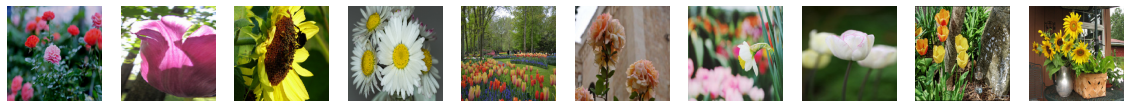

In [23]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(nrows=1,ncols=10,figsize=(20,20))
for i in range(10):
    ax[i].imshow(train_dataset[0][0][i])
    ax[i].axis('off')


In [5]:
def hard_swish(features):

  
  features = tf.convert_to_tensor(features)
  fdtype = features.dtype
  return features * tf.nn.relu6(features + tf.cast(3., fdtype)) * (1. / 6.)

In [6]:
def se_block(inputs, ch, ratio=16):

    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(ch//ratio, activation='relu')(x)
    y = tf.keras.layers.Dense(ch, activation='sigmoid')(x)
    y = tf.keras.layers.multiply([inputs, y])
    out = hard_swish(y)
    return out

In [7]:
def dep_bn(inputs, filter : int, kernel :int, stride: int):

  y = tf.keras.layers.Conv2D(filters = filter, kernel_size= kernel, strides= stride, padding= 'same')(inputs)
  bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
  out = tf.nn.relu6(bn)
  
  return out


def Inverted_residual_SEblock(x,  hs: bool, se: bool , filters, kernel, strides,  expansion_ratio ):


    #pointwise
    y = tf.keras.layers.Conv2D(filters = x.get_shape().as_list()[-1]*expansion_ratio, kernel_size=  1, strides = 1, padding= 'same')(x)
    bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
    if hs:
        y_p = hard_swish(bn)
    else:
        y_p = tf.nn.relu6(bn)
    
    
    #depthwise
    y = tf.keras.layers.DepthwiseConv2D(kernel_size=  kernel, strides= strides, padding= 'same', depth_multiplier = 1)(y_p)
    bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
    if hs:
        out = hard_swish(bn)
    else:
        out = tf.nn.relu6(bn)
   
    
    if se: 
        channel = out.get_shape().as_list()[-1]
        out = se_block(out, channel)

    
    #pointwise
    y = tf.keras.layers.Conv2D(filters = filters, kernel_size=  1, strides = 1, padding= 'same')(out)
    bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
    if hs:
        y_p = hard_swish(bn)
    else:
        y_p = tf.nn.relu6(bn)
        
        
    
    if strides == 1:
        if x.shape[3] != filters : 
           x = tf.keras.layers.Conv2D(filters = filters, kernel_size = 1, strides = strides, padding = "same")(x)
        out  = tf.keras.layers.Add()([x, y_p])
   
    

    return y


In [8]:
def create_mobilenetV3(inputs):

   x = dep_bn(inputs, 16, 3, 2)
   x = Inverted_residual_SEblock(x, False, False, 16, 3, 1,1)

   x = Inverted_residual_SEblock(x, False, False, 24, 3, 2, 4)
   x = Inverted_residual_SEblock(x, False, False, 24, 3, 1, 3)
   
   x = Inverted_residual_SEblock(x, False, True, 40, 5, 2, 3)
   x = Inverted_residual_SEblock(x, False, True, 40, 5, 1, 3)
   x = Inverted_residual_SEblock(x, False, True, 40, 5, 1, 3)

   x = Inverted_residual_SEblock(x, True, False, 80, 3, 2, 6)
   x = Inverted_residual_SEblock(x, True, False, 80, 3, 1, 2.5)
   x = Inverted_residual_SEblock(x, True, False, 80, 3, 1, 184/80)
   x = Inverted_residual_SEblock(x, True, False, 80, 3, 1, 184/80)
    
   x = Inverted_residual_SEblock(x, True, True, 112, 3, 1, 6)
   x = Inverted_residual_SEblock(x, True, True, 112, 3, 1, 6)
    
   x = Inverted_residual_SEblock(x, True, True, 160, 5, 2, 6)
   
   x = Inverted_residual_SEblock(x, True, True, 160, 5, 1, 6)
   x = Inverted_residual_SEblock(x, True, True, 160, 5, 1, 6)
   x = dep_bn(x, 960, 1, 1)
   
   t = tf.keras.layers.AveragePooling2D(1)(x)
   t = tf.keras.layers.Flatten()(t)
   outputs = tf.keras.layers.Dense(6, activation='softmax')(t)
   return outputs

In [9]:
# model = tf.keras.applications.MobileNetV3Large()

In [10]:
inputs = tf.keras.Input(shape=(224,224,3))
outputs = create_mobilenetV3(inputs)

model = tf.keras.Model(inputs, outputs)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

In [25]:
model.fit(train_dataset, validation_data=validation_dataset, epochs = 30)

Epoch 1/30
217/217 [==============================] - 21s 96ms/step - loss: 1.6597 - accuracy: 0.4809 - val_loss: 1.5105 - val_accuracy: 0.5006
Epoch 2/30
217/217 [==============================] - 21s 96ms/step - loss: 1.5220 - accuracy: 0.4956 - val_loss: 1.4966 - val_accuracy: 0.5006
Epoch 3/30
217/217 [==============================] - 21s 97ms/step - loss: 1.5103 - accuracy: 0.4976 - val_loss: 1.5005 - val_accuracy: 0.5006
Epoch 4/30
217/217 [==============================] - 21s 96ms/step - loss: 1.4998 - accuracy: 0.4995 - val_loss: 1.4952 - val_accuracy: 0.5006
Epoch 5/30
217/217 [==============================] - 21s 96ms/step - loss: 1.4849 - accuracy: 0.4988 - val_loss: 1.5011 - val_accuracy: 0.5006
Epoch 6/30
217/217 [==============================] - 21s 96ms/step - loss: 1.4714 - accuracy: 0.4996 - val_loss: 1.4834 - val_accuracy: 0.5006
Epoch 7/30
217/217 [==============================] - 21s 97ms/step - loss: 1.4620 - accuracy: 0.4986 - val_loss: 1.5416 - val_accuracy:

In [104]:
import numpy as np
def making_ypred(predictions):
    pred2s = []
    for pred in predictions:
        pred2s.append(np.argmax(pred))
    return pred2s

predictions = model.predict(validation_dataset[0][0])
y_pred = np.asarray(making_ypred(predictions))
y_pred.shape

(32,)

In [113]:
def index_output(prediction) :
    
    index_list = []
    for pred in prediction:
        i = np.argmax(pred)
        index_list.append(i)
    return index_list

In [114]:
np.array(index_output(predictions)).shape

(32,)

In [115]:
Y_true =[]
for y in y_true:
    Y_true.append(np.where(y==1))
Y_true = np.squeeze(np.asarray(Y_true))
Y_true.shape

(32,)

In [116]:
y_true = validation_dataset[0][1]
from sklearn.metrics import classification_report

print(classification_report(Y_true, y_pred))

              precision    recall  f1-score   support

           0       0.15      0.67      0.25         3
           1       0.00      0.00      0.00         1
           2       0.33      0.35      0.34        17
           3       0.00      0.00      0.00         3
           4       1.00      0.20      0.33         5
           5       0.00      0.00      0.00         3

    accuracy                           0.28        32
   macro avg       0.25      0.20      0.15        32
weighted avg       0.35      0.28      0.26        32



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
